# Languages and Proficiency

This example demonstrates many-to-many relationships using an association table with international standards. You'll learn:

- **Many-to-many relationships** — People speak multiple languages; languages have multiple speakers
- **Lookup tables** — Standardized reference data (ISO language codes, CEFR levels)
- **Association tables** — Linking entities with additional attributes
- **Complex queries** — Aggregations, filtering, and joins

## International Standards

This example uses two widely-adopted standards:

- **ISO 639-1** — Two-letter language codes (`en`, `es`, `ja`)
- **CEFR** — Common European Framework of Reference for language proficiency (A1–C2)

Using international standards ensures data consistency and enables integration with external systems.

In [1]:
import datajoint as dj
import numpy as np
from faker import Faker

dj.config['display.limit'] = 8

# Clean start
schema = dj.Schema('tutorial_languages')
schema.drop(prompt=False)
schema = dj.Schema('tutorial_languages')

[2026-01-23 17:30:47,927][INFO]: DataJoint 2.1.0a6 connected to root@127.0.0.1:3306


## Lookup Tables

Lookup tables store standardized reference data that rarely changes. The `contents` attribute pre-populates them when the schema is created.

In [2]:
@schema
class Language(dj.Lookup):
    definition = """
    # ISO 639-1 language codes
    lang_code : char(2)             # two-letter code (en, es, ja)
    ---
    language : varchar(30)          # full name
    native_name : varchar(50)       # name in native script
    """
    contents = [
        ('ar', 'Arabic', 'العربية'),
        ('de', 'German', 'Deutsch'),
        ('en', 'English', 'English'),
        ('es', 'Spanish', 'Español'),
        ('fr', 'French', 'Français'),
        ('hi', 'Hindi', 'हिन्दी'),
        ('ja', 'Japanese', '日本語'),
        ('ko', 'Korean', '한국어'),
        ('pt', 'Portuguese', 'Português'),
        ('uk', 'Ukrainian', 'Українська'),
        ('zh', 'Chinese', '中文'),
    ]

In [3]:
@schema
class CEFRLevel(dj.Lookup):
    definition = """
    # CEFR proficiency levels
    cefr_level : char(2)            # A1, A2, B1, B2, C1, C2
    ---
    level_name : varchar(20)        # descriptive name
    category : enum('Basic', 'Independent', 'Proficient')
    description : varchar(100)      # can-do summary
    """
    contents = [
        ('A1', 'Beginner', 'Basic',
         'Can use familiar everyday expressions'),
        ('A2', 'Elementary', 'Basic',
         'Can communicate in simple routine tasks'),
        ('B1', 'Intermediate', 'Independent',
         'Can deal with most travel situations'),
        ('B2', 'Upper Intermediate', 'Independent',
         'Can interact with fluency and spontaneity'),
        ('C1', 'Advanced', 'Proficient',
         'Can express ideas fluently for professional use'),
        ('C2', 'Mastery', 'Proficient',
         'Can understand virtually everything'),
    ]

In [4]:
print("Languages:")
print(Language())
print("\nCEFR Levels:")
print(CEFRLevel())

Languages:
*lang_code    language     native_name   
+-----------+ +----------+ +------------+
ar            Arabic       العربية       
de            German       Deutsch       
en            English      English       
es            Spanish      Español       
fr            French       Français      
hi            Hindi        हिन्दी        
ja            Japanese     日本語           
ko            Korean       한국어           
   ...
 (Total: 11)


CEFR Levels:
*cefr_level    level_name     category       description   
+------------+ +------------+ +------------+ +------------+
A1             Beginner       Basic          Can use famili
A2             Elementary     Basic          Can communicat
B1             Intermediate   Independent    Can deal with 
B2             Upper Intermed Independent    Can interact w
C1             Advanced       Proficient     Can express id
C2             Mastery        Proficient     Can understand
 (Total: 6)



## Entity and Association Tables

- **Person** — The main entity
- **Proficiency** — Association table linking Person, Language, and CEFRLevel

The association table's primary key includes both Person and Language, creating the many-to-many relationship.

In [5]:
@schema
class Person(dj.Manual):
    definition = """
    # People with language skills
    person_id : int32               # unique identifier
    ---
    name : varchar(60)
    date_of_birth : date
    """

In [6]:
@schema
class Proficiency(dj.Manual):
    definition = """
    # Language proficiency (many-to-many: person <-> language)
    -> Person
    -> Language
    ---
    -> CEFRLevel
    """

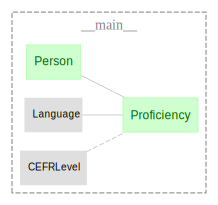

In [7]:
dj.Diagram(schema)

**Reading the diagram:**
- **Gray tables** (Language, CEFRLevel) are Lookup tables
- **Green table** (Person) is Manual
- **Solid lines** indicate foreign keys in the primary key (many-to-many)
- **Dashed line** indicates foreign key in secondary attributes (reference)

## Populate Sample Data

In [8]:
np.random.seed(42)
fake = Faker()
fake.seed_instance(42)

# Generate 200 people
n_people = 200
Person.insert(
    {
        'person_id': i,
        'name': fake.name(),
        'date_of_birth': fake.date_of_birth(
            minimum_age=18, maximum_age=70)
    }
    for i in range(n_people)
)

print(f"Created {len(Person())} people")
Person()

Created 200 people


person_id unique identifier,name,date_of_birth
0,Allison Hill,1966-11-21
1,Megan Mcclain,1959-09-01
2,Allen Robinson,1981-11-04
3,Cristian Santos,1983-12-10
4,Kevin Pacheco,1955-05-28
5,Melissa Peterson,1963-04-20
6,Gabrielle Davis,1960-03-09
7,Lindsey Roman,1993-09-26


In [9]:
# Assign random language proficiencies
lang_keys = list(Language.keys())
cefr_keys = list(CEFRLevel.keys())

# More people at intermediate levels than extremes
cefr_weights = [0.08, 0.12, 0.20, 0.25, 0.20, 0.15]
avg_languages = 2.5

for person_key in Person.keys():
    n_langs = np.random.poisson(avg_languages)
    if n_langs > 0:
        selected_langs = np.random.choice(
            len(lang_keys), min(n_langs, len(lang_keys)), replace=False)
        Proficiency.insert(
            {
                **person_key,
                **lang_keys[i],
                **np.random.choice(cefr_keys, p=cefr_weights)
            }
            for i in selected_langs
        )

print(f"Created {len(Proficiency())} proficiency records")
Proficiency()

Created 527 proficiency records


person_id unique identifier,"lang_code two-letter code (en, es, ja)","cefr_level A1, A2, B1, B2, C1, C2"
0,ar,A1
0,de,B2
0,hi,C2
0,uk,B2
3,de,B2
3,uk,A1
4,hi,B2
4,pt,C1


## Query Examples

### Finding Speakers

In [10]:
# Proficient English speakers (C1 or C2)
proficient_english = (
    Person.proj('name') & 
    (Proficiency & {'lang_code': 'en'} & "cefr_level >= 'C1'")
)
print(f"Proficient English speakers: {len(proficient_english)}")
proficient_english

Proficient English speakers: 18


person_id unique identifier,name,date_of_birth
22,Brian Burton,bytes
32,Elizabeth Brown,bytes
33,Angelica Tucker,bytes
37,Zachary Santos,bytes
38,Barbara Walker,bytes
42,Timothy Duncan,bytes
53,Whitney Peters,bytes
67,Teresa Taylor,bytes


In [11]:
# People who speak BOTH English AND Spanish
bilingual = (
    Person.proj('name') & 
    (Proficiency & {'lang_code': 'en'}) & 
    (Proficiency & {'lang_code': 'es'})
)
print(f"English + Spanish speakers: {len(bilingual)}")
bilingual

English + Spanish speakers: 6


person_id unique identifier,name,date_of_birth
38,Barbara Walker,bytes
67,Teresa Taylor,bytes
77,Richard Henson,bytes
113,Denise Jones,bytes
122,Michael Powell,bytes
137,Lindsay Martinez,bytes


In [12]:
# People who speak English OR Spanish
either = (
    Person.proj('name') & 
    (Proficiency & "lang_code in ('en', 'es')")
)
print(f"English or Spanish speakers: {len(either)}")
either

English or Spanish speakers: 79


person_id unique identifier,name,date_of_birth
6,Gabrielle Davis,bytes
11,David Garcia,bytes
12,Holly Wood,bytes
17,Daniel Hahn,bytes
19,Derek Wright,bytes
20,Kevin Hurst,bytes
22,Brian Burton,bytes
27,Sherri Baker,bytes


### Aggregations

In [13]:
# People who speak 4+ languages
polyglots = Person.aggr(
    Proficiency,
    'name',
    n_languages='COUNT(lang_code)',
    languages='GROUP_CONCAT(lang_code)'
) & 'n_languages >= 4'

print(f"Polyglots (4+ languages): {len(polyglots)}")
polyglots

Polyglots (4+ languages): 56


person_id unique identifier,name,n_languages calculated attribute,languages calculated attribute
0,Allison Hill,4,"ar,de,hi,uk"
6,Gabrielle Davis,5,"de,en,fr,hi,uk"
8,Valerie Gray,4,"de,hi,ko,zh"
9,Lisa Hensley,4,"ar,ja,pt,zh"
11,David Garcia,4,"es,hi,ko,zh"
12,Holly Wood,4,"de,en,pt,uk"
14,Nicholas Martin,5,"fr,hi,ko,pt,zh"
15,Margaret Hawkins DDS,4,"de,fr,ja,uk"


In [14]:
# Top 5 polyglots
top_polyglots = Person.aggr(
    Proficiency,
    'name',
    n_languages='COUNT(lang_code)'
) & dj.Top(5, order_by='n_languages DESC')

top_polyglots

person_id unique identifier,name,n_languages calculated attribute
58,Bryan Zamora,7
116,Joshua Perry,7
77,Richard Henson,7
20,Kevin Hurst,7
42,Timothy Duncan,7


In [15]:
# Number of speakers per language
speakers_per_lang = Language.aggr(
    Proficiency,
    'language',
    n_speakers='COUNT(person_id)'
)
speakers_per_lang

"lang_code two-letter code (en, es, ja)",language full name,n_speakers calculated attribute
ar,Arabic,41
de,German,55
en,English,45
es,Spanish,40
fr,French,49
hi,Hindi,54
ja,Japanese,47
ko,Korean,47


In [16]:
# CEFR level distribution for English
english_levels = CEFRLevel.aggr(
    Proficiency & {'lang_code': 'en'},
    'level_name',
    n_speakers='COUNT(person_id)'
)
english_levels

"cefr_level A1, A2, B1, B2, C1, C2",level_name descriptive name,n_speakers calculated attribute
A1,Beginner,1
A2,Elementary,5
B1,Intermediate,8
B2,Upper Intermediate,13
C1,Advanced,13
C2,Mastery,5


### Joining Tables

In [17]:
# Full profile: person + language + proficiency details
full_profile = (
    Person * Proficiency * Language * CEFRLevel
).proj('name', 'language', 'level_name', 'category')

# Show profile for person_id=0
full_profile & {'person_id': 0}

person_id unique identifier,"lang_code two-letter code (en, es, ja)",name,language full name,level_name descriptive name,category
0,ar,Allison Hill,Arabic,Beginner,Basic
0,de,Allison Hill,German,Upper Intermediate,Independent
0,hi,Allison Hill,Hindi,Mastery,Proficient
0,uk,Allison Hill,Ukrainian,Upper Intermediate,Independent


In [18]:
# Find people with C1+ proficiency in multiple languages
advanced_polyglots = Person.aggr(
    Proficiency & "cefr_level >= 'C1'",
    'name',
    n_advanced='COUNT(*)'
) & 'n_advanced >= 2'

print(f"Advanced in 2+ languages: {len(advanced_polyglots)}")
advanced_polyglots

Advanced in 2+ languages: 49


person_id unique identifier,name,n_advanced calculated attribute
6,Gabrielle Davis,2
7,Lindsey Roman,2
14,Nicholas Martin,3
19,Derek Wright,2
20,Kevin Hurst,3
25,Melanie Herrera,2
27,Sherri Baker,2
29,Lisa Hernandez,2


## Key Concepts

| Pattern | Implementation |
|---------|----------------|
| **Many-to-many** | `Proficiency` links `Person` and `Language` |
| **Lookup tables** | `Language` and `CEFRLevel` with `contents` |
| **Association data** | `cefr_level` stored in the association table |
| **Standards** | ISO 639-1 codes, CEFR levels |

### Benefits of Lookup Tables

1. **Data consistency** — Only valid codes can be used
2. **Rich metadata** — Full names, descriptions stored once
3. **Easy updates** — Change "Español" to "Spanish" in one place
4. **Self-documenting** — `Language()` shows all valid options

## Next Steps

- [University Database](../university) — Academic records
- [Hotel Reservations](../hotel-reservations) — Workflow dependencies
- [Queries Tutorial](../../basics/04-queries) — Query operators in depth

In [19]:
# Cleanup
schema.drop(prompt=False)